# RL Lab 4: Temporal Difference Learning

基于时序差分学习的网格迷宫求解算法。

## 简介

在环境的状态转移矩阵未知的情况下，我们不再能使用动态规划方法来求解最优策略。此时，强化学习中的时序差分（Temporal Difference, TD）学习提供了一种无需完整模型、基于经验进行学习的有效方法。本实验采用TD学习中的SARSA与Q-learning算法，通过智能体与环境的交互不断更新动作价值函数，最终逼近最优策略。在网格迷宫环境中，智能体将逐步学习在未知环境中如何高效地到达目标状态。

## 目标

- 在`GridWorldEnvironment`的基础上实现基于时序差分学习的SARSA算法和Q-Learning算法。
- 通过可视化方法显示算法的收敛过程、状态价值函数和策略。

### 扩展



In [1]:
import torch
import random
from matplotlib import pyplot as plt
from rl_env import GridEnvironment

%config InlineBackend.figure_format = 'svg'

# seed = random.randint(0, 10000)
seed = 7080
print(f"Seed: {seed}")
torch.manual_seed(seed)
random.seed(seed)

Seed: 7080


生成迷宫

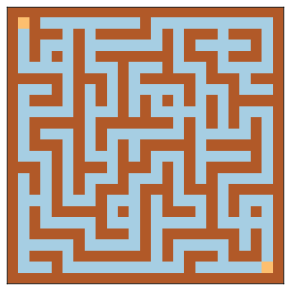

In [2]:
env = GridEnvironment(25, 25, wall_ratio=0.07)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

grid_to_show = 2 * env.grid.clone().cpu().numpy()
grid_to_show[*env.starting_state] = 1
grid_to_show[*env.ending_state] = 1

ax.imshow(grid_to_show, cmap='Paired', interpolation='nearest')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect(env.ncols / env.nrows)

plt.show()

实现智能体。智能体需要维护状态-价值函数。

In [3]:
class TDAgent():
    def __init__(
        self, env, method='sarsa',
        discount_factor=0.9, eps=1e-6, lr=0.1, epsilon_greedy=0.1,
        max_steps=None
    ):
        self.env = env
        self.eps = eps
        self.epsilon_greedy = epsilon_greedy
        self.max_steps = max_steps
        self.current_step = 0

        if method == 'sarsa':
            self.on_policy = True
        elif method == 'q_learning':
            self.on_policy = False
        else:
            raise ValueError("method must be 'sarsa' or 'q_learning'")

        self.discount_factor = discount_factor
        self.lr = lr

        self.action_values = torch.randn(
            env.num_states, env.num_actions, device=env.device
        ) * (self.eps ** 0.5)
        self.policy = self.action_values.argmax(dim=1)

    @property
    def state_values(self):
        return self.action_values.max(dim=1).values

    def step(self) -> float:
        # 1. Get states and actions
        states = torch.arange(self.env.num_states, device=self.env.device)
        actions = self.policy[states]
        # 2. Get rewards and next states
        next_states, rewards = self.env.sample_state_transition(states, actions)
        # 3. TD iteration
        if self.on_policy:
            # SARSA: epsilon-greedy policy
            next_actions = self.policy[next_states]
            next_actions = torch.where(
                torch.rand_like(next_states, dtype=torch.float) < self.epsilon_greedy,
                torch.randint(0, self.env.num_actions, size=next_states.shape),
                next_actions
            )
            td_update = rewards + self.discount_factor * \
                self.action_values[next_states, next_actions] - \
                self.action_values[states, actions]
        else:
            # Q-learning
            policy = self.action_values[next_states].argmax(dim=1)
            next_actions = torch.where(
                torch.rand_like(next_states, dtype=torch.float) < self.epsilon_greedy,
                torch.randint(0, self.env.num_actions, size=next_states.shape),
                policy
            )
            td_update = rewards + self.discount_factor * \
                self.action_values[next_states, next_actions] - \
                self.action_values[states, actions]
        # 6. Update action values and policy
        self.action_values[states, actions] += self.lr * td_update
        self.policy[states] = self.action_values[states].argmax(dim=1)
        # 7. Check convergence
        return td_update.abs().max().item()

    def __iter__(self):
        return self

    def __next__(self):
        if self.max_steps is not None and self.current_step >= self.max_steps:
                raise StopIteration
        self.current_step += 1
        delta = self.step()
        if delta < self.eps:
            raise StopIteration
        return delta

agent_kwargs = {
    'discount_factor': 0.99,
    'eps': 1e-2,
    'lr': 0.1,
    'epsilon_greedy': 0,
    'max_steps': 1000,
}
agent_sarsa = TDAgent(env, method='sarsa', **agent_kwargs)
agent_q_learning = TDAgent(env, method='q_learning', **agent_kwargs)
delta_sarsa = [*agent_sarsa]
delta_q_learning = [*agent_q_learning]

/Users/huangfusl/Documents/GitHub/HuangFuSL.github.io/docs/coding/machine-learning/rl_env.py:174: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  result = torch.sparse.mm(selector, tensor)


显示策略更新过程。

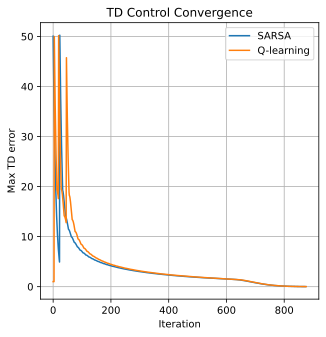

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(delta_sarsa, label='SARSA')
ax.plot(delta_q_learning, label='Q-learning')
ax.set_xlabel('Iteration')
ax.set_ylabel('Max TD error')
ax.set_title('TD Control Convergence')
ax.grid()
ax.legend(loc='upper right')
plt.show()

显示状态值和策略

In [5]:
def display_policy(agent: TDAgent):

    fig, (ax_path, ax_state, ax_cmap) = plt.subplots(1, 3, figsize=(10, 4), width_ratios=[1, 1, 0.1])

    ax_path.set_title('Main Path')
    state = agent.env.starting_state
    path = [state]
    for _ in range(100):
        if state == agent.env.ending_state:
            break
        action = agent.policy[agent.env.get_state(state)].item()
        next_state = state + agent.env.get_action(action)
        path.append(next_state)
        state = next_state
    path_grid = grid_to_show.copy()
    for index, (i, j) in enumerate(path):
        path_grid[i, j] = 1
    ax_path.imshow(path_grid, cmap='Paired')

    ax_state.set_title('State Values')
    state_values_to_show = torch.full((agent.env.nrows, agent.env.ncols), torch.nan)
    for i, value in enumerate(agent.state_values):
        state = agent.env.get_state(i)
        state_values_to_show[*state] = value.item()
    ax_state.imshow(state_values_to_show.cpu().numpy(), cmap='viridis', interpolation='nearest')
    fig.colorbar(ax_state.images[0], cax=ax_cmap, orientation='vertical')

    for ax in (ax_path, ax_state):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect(agent.env.ncols / agent.env.nrows)

    plt.show()

SARSA算法

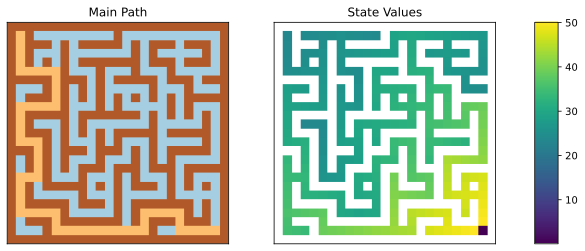

In [6]:
display_policy(agent_sarsa)

Q-Learning算法

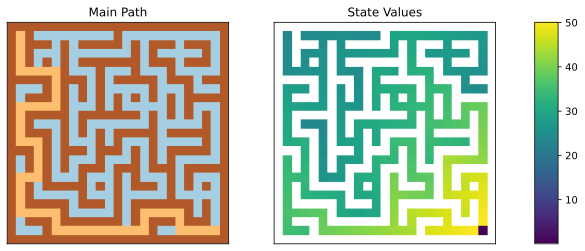

In [7]:
display_policy(agent_q_learning)